In [1]:
import cv2
import os
import fnmatch
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from roi import setting_roi
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

In [3]:
class datamaker:
    def __init__(self, source_path, categories, roi, train_sample):
        self.source_path = source_path
        self.categories = categories
        self.roi = roi
        self.train_sample = train_sample
        self.train_image, self.train_label, self.val_image, self.val_label = [], [], [], []
        self.train_set, self.val_set = [], []

        self.validation_sample = 0.1
        self.width, self.height = 150, 150

    def __call__(self, *args, **kwargs):
        self.load_set()

        self.train_val_set(self.train_set, self.train_image, self.train_label)
        self.train_val_set(self.val_set, self.val_image, self.val_label)

        return (self.train_image, self.val_image, self.train_label, self.val_label)

    def load_set(self):
        for cat in self.categories:
            path = f"{self.source_path}/{cat}"

            if not os.path.isdir(path):
                print(f"{cat} is not exists. please check your category or directory")
                break

            img_file_list = fnmatch.filter(os.listdir(path), "*.jpg")
            random.shuffle(img_file_list)

            if len(img_file_list) < self.train_sample:
                print("Insufficient dataset.")
                break

            img_file_list = img_file_list[:self.train_sample]
            # print(img_file_list)

            val_number = int(self.train_sample * self.validation_sample)
            train_number = self.train_sample - val_number

            label = categories.index(cat)

            for img in img_file_list[:train_number]:
                img_path = f"{path}/{img}"
                self.train_set.append([img_path, label])

            for img in img_file_list[train_number:]:
                img_path = f"{path}/{img}"
                self.val_set.append([img_path, label])

        random.shuffle(self.train_set)
        random.shuffle(self.val_set)

    def train_val_set(self, dataset, img_list, label_list):
        for imgs, label in dataset:
            img = cv2.imread(imgs)
            for (i, j) in self.roi:
                x, y = i * self.width, j * self.height
                roi_img = img[y:y + self.height, x:x + self.width]

                img_list.append(roi_img)
                label_list.append(label)

In [33]:
source_path = './201'
categories = ['dry_day', 'dry_night', 'wet_day', 'wet_night']
roi = setting_roi('33A_201')
# roi = [(0, 5), (0, 7), (0, 8), (0, 9), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 5), (2, 6), (2, 10), (3, 3), (3, 5), (3, 9), (4, 7)]
train_sample = 35

In [34]:
loaded = datamaker(source_path=source_path, categories=categories, roi=roi, train_sample=train_sample)
(x_train, x_test, y_train, y_test) = loaded()

In [35]:
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0
y_train = to_categorical(y_train, len(categories))
y_test = to_categorical(y_test, len(categories))

In [7]:
len(roi)

16

In [36]:
model = load_model('./model/tfl_13.tf/')

In [37]:
new_model = Sequential(model.layers[:-1])

In [38]:
new_model.add(Dense(len(categories), activation='softmax'))

In [39]:
for layer in new_model.layers[:-1]:
    layer.trainable = False

In [40]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_a (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense_a (Dense)              (None, 64)               

In [41]:
new_model.compile(loss = "categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [42]:
history = new_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Train on 2048 samples, validate on 192 samples
Epoch 1/100
2048/2048 [==============================] - 5s 2ms/sample - loss: 19.0180 - accuracy: 0.3037 - val_loss: 8.1163 - val_accuracy: 0.3646
Epoch 2/100
2048/2048 [==============================] - 1s 656us/sample - loss: 14.4400 - accuracy: 0.3530 - val_loss: 6.5017 - val_accuracy: 0.3698
Epoch 3/100
2048/2048 [==============================] - 1s 650us/sample - loss: 12.8910 - accuracy: 0.3638 - val_loss: 5.2272 - val_accuracy: 0.3906
Epoch 4/100
2048/2048 [==============================] - 1s 660us/sample - loss: 11.7794 - accuracy: 0.3818 - val_loss: 4.3638 - val_accuracy: 0.4219
Epoch 5/100
2048/2048 [==============================] - 1s 660us/sample - loss: 10.0257 - accuracy: 0.4136 - val_loss: 3.9408 - val_accuracy: 0.4115
Epoch 6/100
2048/2048 [==============================] - 1s 651us/sample - loss: 9.9283 - accuracy: 0.4224 - val_loss: 3.6857 - val_accuracy: 0.4271
Epoch 7/100
2048/2048 [==============================] -

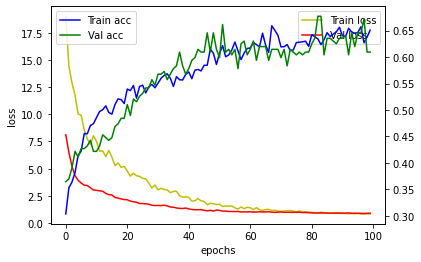

In [43]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='Train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='Val loss')
loss_ax.set_xlabel("epochs")
loss_ax.set_ylabel("loss")
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['accuracy'], 'b', label = 'Train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'Val acc')
acc_ax.set_xlabel("Accuracy")
acc_ax.legend(loc="upper left")

plt.show()

In [44]:
for layer in new_model.layers[:-1]:
    layer.trainable = True

In [45]:
new_model.compile(loss = "categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [46]:
start = datetime.now()
ck = ModelCheckpoint(f'{start.strftime("%Y%m%d_%H%M%S")}_transfer_learning_{train_sample}_2.tf', save_best_only=True)

In [47]:
history = new_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test), callbacks=[ck])

Train on 2048 samples, validate on 192 samples
Epoch 1/100
2048/2048 [==============================] - 7s 3ms/sample - loss: 0.8560 - accuracy: 0.6221 - val_loss: 1.0488 - val_accuracy: 0.5885
Epoch 2/100
2048/2048 [==============================] - 5s 3ms/sample - loss: 0.7345 - accuracy: 0.6592 - val_loss: 0.8846 - val_accuracy: 0.6094
Epoch 3/100
2048/2048 [==============================] - 5s 2ms/sample - loss: 0.6281 - accuracy: 0.7192 - val_loss: 0.6921 - val_accuracy: 0.7292
Epoch 4/100
2048/2048 [==============================] - 3s 2ms/sample - loss: 0.5962 - accuracy: 0.7241 - val_loss: 0.7652 - val_accuracy: 0.6875
Epoch 5/100
2048/2048 [==============================] - 5s 2ms/sample - loss: 0.5780 - accuracy: 0.7441 - val_loss: 0.6793 - val_accuracy: 0.7448
Epoch 6/100
2048/2048 [==============================] - 5s 2ms/sample - loss: 0.5420 - accuracy: 0.7607 - val_loss: 0.6415 - val_accuracy: 0.7656
Epoch 7/100
2048/2048 [==============================] - 5s 2ms/sample 

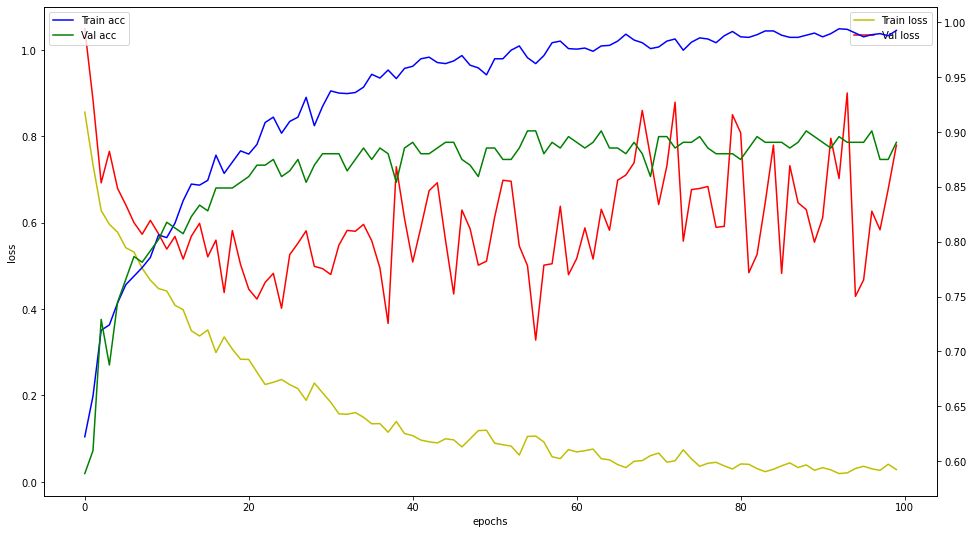

In [48]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='Train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='Val loss')
loss_ax.set_xlabel("epochs")
loss_ax.set_ylabel("loss")
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['accuracy'], 'b', label = 'Train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'Val acc')
acc_ax.set_xlabel("Accuracy")
acc_ax.legend(loc="upper left")

fig.set_figwidth(16)
fig.set_figheight(9)

plt.show()

In [49]:
new_model.evaluate(x_test, y_test)

192/192 [==============================] - 0s 895us/sample - loss: 0.7795 - accuracy: 0.8906


[0.77947937692079, 0.890625]

In [26]:
test_model = load_model(f'{start.strftime("%Y%m%d_%H%M%S")}_transfer_learning_{train_sample}_2.tf')

In [27]:
roi = setting_roi('33A_201')

In [28]:
width, height = 150, 150

In [29]:
test_path = "./test"

In [30]:
categories = os.listdir(test_path)

In [31]:
cat_kor = ['건조_주간', '건조_야간', '습윤_주간', '습윤_야간']

In [32]:
for cat in categories:
    path = f"{test_path}/{cat}"
    img_list = fnmatch.filter(os.listdir(path), "*.jpg")
    
    label = categories.index(cat)
    count = 0
    
    for imgs in img_list:
        roi_set = []
        img_path = f"{path}/{imgs}"
        img = cv2.imread(img_path)
        for (i, j) in roi:
            x, y = i * width, j * height
            roi_img = img[y:y+height, x:x+width]
            roi_set.append(roi_img)
        
        roi_set = np.array(roi_set) / 255.
        roi_set = roi_set.reshape(-1, width, height, 3)
        
        preds = test_model.predict(roi_set)
        
        pred_values = []
        
        for pred in preds:
            pred_values.append(np.argmax(pred))
            
        pred_list = []
        
        for i in range(len(categories)):
            pred_list.append(pred_values.count(i))
            
        
        if np.argmax(pred_list) == label:
            count += 1
    
    print(f"{cat_kor[label]}: {count / len(img_list) * 100:.2f}%")
            

건조_주간: 96.50%
건조_야간: 100.00%
습윤_주간: 95.75%
습윤_야간: 99.12%
